In [41]:
import pandas as pd
import dateutil.parser
import os
import random
from pytz import timezone
import datetime as dt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels.formula.api as smf

In [2]:
#load intraday CSV. This comes from downloader v4
input_filename = "full_intraday_data_20210306_162459.csv"
cols = pd.read_csv(input_filename, nrows=1).columns
df = pd.read_csv(input_filename, usecols=cols[1:])

#drop unused features for performance
df.drop(columns=['open','close','last','exchange'],inplace=True)

#dedupe rows
df.drop_duplicates(keep='first',inplace=True)
print(str(len(df)) + ' rows')
df = df.sort_values(by=['symbol','date'])

#parse dates
for i, row in df.iterrows():
    df.at[i,'pydate'] = dateutil.parser.parse(row.date)
print('all rows parsed')

#convert timezones to Eastern (NYC)
df['pydate'] = pd.to_datetime(df['pydate'])
df['nydt'] = df['pydate'].dt.tz_convert(timezone('US/Hawaii'))
df.drop(columns=['date','pydate'],inplace=True)
df.head()

985626 rows
all rows parsed


,high,low,volume,symbol,nydt
46818,62.500,61.930,NaN,A,2018-05-29 08:00:00-10:00
46817,62.070,61.595,NaN,A,2018-05-29 09:00:00-10:00
46816,61.940,61.320,NaN,A,2018-05-29 10:00:00-10:00
46815,61.770,61.440,NaN,A,2018-05-29 11:00:00-10:00
46814,61.615,61.320,NaN,A,2018-05-29 12:00:00-10:00


In [3]:
#Finish preparing the intraday data
df2 = df

df2['date'] = df2['nydt'].dt.date
df2['time'] = df2['nydt'].dt.time
df2['hour'] = df2['nydt'].dt.hour
df2['avgp'] = df2.loc[:,'high':'low'].mean(axis=1)
df2.head()

# export_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
# csv_name = os.getcwd() + '/output/df_preview_' + export_ts + '.csv'
# df2.to_csv(csv_name)
print("Done")

Done. Output saved to /Users/mike/Desktop/ml_final/dataprep/df_preview_20210307_122254.csv


In [4]:
#load the EOD CSV, which has our Y values. This comes from downloader v4_EOD edition
eodinput = "full_eod_data_20210306_221055.csv"
eodcols = pd.read_csv(eodinput, nrows=1).columns
eoddf = pd.read_csv(eodinput, usecols=eodcols[1:])

#drop unused features for performance
eoddf = eoddf[['close','symbol','date']]

#dedupe rows
eoddf.drop_duplicates(keep='first',inplace=True)
print(str(len(eoddf)) + ' rows')

#parse dates
for i, row in eoddf.iterrows():
    eoddf.at[i,'date2'] = dateutil.parser.parse(row.date).date()
print('all rows parsed')
eoddf.drop(columns=['date'],inplace=True)
eoddf['date'] = eoddf['date2']
eoddf.drop(columns=['date2'],inplace=True)
print("done")

532900 rows
all rows parsed
done


In [5]:
# Do a quick data quality check
# print(df2.head())
print(df2.isnull().sum()/len(df2))

high      0.000000
low       0.000000
volume    0.559013
symbol    0.000000
nydt      0.000000
date      0.000000
time      0.000000
hour      0.000000
avgp      0.000000
dtype: float64


In [6]:
# Figure out which days are trading days (the data checks out manually so I don't need to run this all the time)
# volbyday = df2.groupby(['date','symbol'])[['volume']].agg('sum')
# print(volbyday)
# volbyday.to_csv(os.getcwd() + '/filter_volume_by_day' + datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv')

#Prep list of stock trading days and backward looking days
tradeDates = pd.DataFrame(df2.date.unique(), columns=['date'])
tradeDates.sort_values(by=['date'])
for i in range(1,11):
    tradeDates['lagdate' + str(i)] = tradeDates['date'].shift(i)
tradeDates = tradeDates.dropna(subset=['lagdate10'])
tradeDates.head()


,date,lagdate1,lagdate2,lagdate3,lagdate4,lagdate5,lagdate6,lagdate7,lagdate8,lagdate9,lagdate10
10,2018-06-12,2018-06-11,2018-06-08,2018-06-07,2018-06-06,2018-06-05,2018-06-04,2018-06-01,2018-05-31,2018-05-30,2018-05-29
11,2018-06-13,2018-06-12,2018-06-11,2018-06-08,2018-06-07,2018-06-06,2018-06-05,2018-06-04,2018-06-01,2018-05-31,2018-05-30
12,2018-06-14,2018-06-13,2018-06-12,2018-06-11,2018-06-08,2018-06-07,2018-06-06,2018-06-05,2018-06-04,2018-06-01,2018-05-31
13,2018-06-15,2018-06-14,2018-06-13,2018-06-12,2018-06-11,2018-06-08,2018-06-07,2018-06-06,2018-06-05,2018-06-04,2018-06-01
14,2018-06-18,2018-06-15,2018-06-14,2018-06-13,2018-06-12,2018-06-11,2018-06-08,2018-06-07,2018-06-06,2018-06-05,2018-06-04


In [7]:
# Grab the ten o'clock prices as the basis of the training/CV/test sets
# Then, merge on the prices from the same date

tens = df2[df2['hour'] == 10]
tens = tens.drop_duplicates(subset=['date','symbol'],keep='first')
dfmerged = pd.merge(tens,tradeDates,on='date')

# nines = df2[df2['hour'] == 9].rename(columns={'avgp':'avgp_minus1'})[['date','symbol','avgp_minus1']]

for hr in range(9,17):
    if hr != 10:
        print(hr)
        if hr == 9:
            colName = 'avgp_minus1'
        else:
            colName = 'avgp_sd' + str(hr)
        joindf = df2[df2['hour'] == hr].rename(columns={'avgp':colName})[['date','symbol',colName]]
        joindf = joindf.drop_duplicates(subset=['date','symbol'],keep='first')
        dfmerged = pd.merge(dfmerged,joindf, left_on=['date','symbol'], right_on=['date','symbol'], how='left')
        dfmerged[colName] = dfmerged[colName]/dfmerged['avgp']
dfmerged.head()

9
11
12
13
14
15
16


,high,low,volume,symbol,nydt,date,time,hour,avgp,lagdate1,...,lagdate8,lagdate9,lagdate10,avgp_minus1,avgp_sd11,avgp_sd12,avgp_sd13,avgp_sd14,avgp_sd15,avgp_sd16
0,66.540,66.19,NaN,A,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,66.3650,2018-06-11,...,2018-05-31,2018-05-30,2018-05-29,0.999397,1.000866,0.999849,0.999360,0.998719,NaN,NaN
1,43.660,43.17,NaN,AAL,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,43.4150,2018-06-11,...,2018-05-31,2018-05-30,2018-05-29,1.005298,1.003743,1.000346,0.998272,1.000115,NaN,NaN
2,134.415,133.37,NaN,AAP,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,133.8925,2018-06-11,...,2018-05-31,2018-05-30,2018-05-29,1.001120,0.999216,0.997666,0.997461,0.998338,NaN,NaN
3,192.600,191.31,NaN,AAPL,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,191.9550,2018-06-11,...,2018-05-31,2018-05-30,2018-05-29,0.997499,1.001328,0.999492,0.999297,1.001901,NaN,NaN
4,99.910,98.75,NaN,ABBV,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,99.3300,2018-06-11,...,2018-05-31,2018-05-30,2018-05-29,0.998465,1.000604,1.003423,0.998641,0.996074,NaN,NaN


In [8]:
# Merge on the prices from the preceeding tens days at hourly intervals, and normalize 
nDaysLookBack = 10
hours = [14,13,12,11,10,9]
# nDaysLookBack = 1
# hours = [16]
minusCounter = 2
outputdf = dfmerged
for d in range(1,nDaysLookBack+1):
    print(d)
    for h in hours:
        priceCol = 'avgp_minus' + str(minusCounter)
        dateCol = 'lagdate' + str(d)
        joindf = df2[df2['hour'] == h]
        joindf = joindf.rename(columns={'avgp':priceCol,'date':dateCol})[[priceCol,dateCol,'symbol']]
        joindf = joindf.drop_duplicates(subset=[dateCol,'symbol'],keep='first')
        outputdf = pd.merge(outputdf, joindf, how='left', on=['symbol',dateCol])
        outputdf[priceCol] = outputdf[priceCol]/outputdf['avgp']
        minusCounter = minusCounter + 1
# outputdf.to_csv(os.getcwd() + '/output/outputdf_' + datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv')

nullcheck = outputdf.isnull().sum()/len(outputdf)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(nullcheck)
print("Done")

1
2
3
4
5
6
7
8
9
10
high            0.000000
low             0.000000
volume          0.732656
symbol          0.000000
nydt            0.000000
date            0.000000
time            0.000000
hour            0.000000
avgp            0.000000
lagdate1        0.000000
lagdate2        0.000000
lagdate3        0.000000
lagdate4        0.000000
lagdate5        0.000000
lagdate6        0.000000
lagdate7        0.000000
lagdate8        0.000000
lagdate9        0.000000
lagdate10       0.000000
avgp_minus1     0.313068
avgp_sd11       0.253232
avgp_sd12       0.253437
avgp_sd13       0.253447
avgp_sd14       0.252943
avgp_sd15       0.751600
avgp_sd16       0.498918
avgp_minus2     0.257653
avgp_minus3     0.264686
avgp_minus4     0.264686
avgp_minus5     0.262317
avgp_minus6     0.077754
avgp_minus7     0.321360
avgp_minus8     0.259136
avgp_minus9     0.275469
avgp_minus10    0.275459
avgp_minus11    0.273053
avgp_minus12    0.088704
avgp_minus13    0.325044
avgp_minus14    0.261300
avgp

In [ ]:
# ualtest = outputdf[outputdf['symbol'].isin(['UAL'])]
# ualtest.to_csv(os.getcwd() + '/ualtest_' + datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv')

In [9]:
outputdf = pd.merge(outputdf, eoddf, left_on=['date','symbol'], right_on=['date','symbol'], how='left')
outputdf['close'] = outputdf['close']/outputdf['avgp']
outputdf.head()

,high,low,volume,symbol,nydt,date,time,hour,avgp,lagdate1,...,avgp_minus53,avgp_minus54,avgp_minus55,avgp_minus56,avgp_minus57,avgp_minus58,avgp_minus59,avgp_minus60,avgp_minus61,close
0,66.540,66.19,NaN,A,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,66.3650,2018-06-11,...,0.947186,0.94534,0.94583,0.932042,0.928652,0.926204,0.928275,0.928652,0.931703,0.999322
1,43.660,43.17,NaN,AAL,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,43.4150,2018-06-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999885
2,134.415,133.37,NaN,AAP,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,133.8925,2018-06-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998114
3,192.600,191.31,NaN,AAPL,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,191.9550,2018-06-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.001693
4,99.910,98.75,NaN,ABBV,2018-06-12 10:00:00-10:00,2018-06-12,10:00:00,10,99.3300,2018-06-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995772


In [10]:
# Filter out observations with flat daily prices
# They can be perfectly predicted using same-day data, but it's just caused by measurement error

outputdf['susCols'] = 0
outputdf['susCols'] = (outputdf['susCols'] + np.where(outputdf['avgp_minus1'] == 1, 1, 0)
                        + outputdf['susCols'] + np.where(outputdf['avgp_sd11'] == 1, 1, 0)
                        + outputdf['susCols'] + np.where(outputdf['avgp_sd12'] == 1, 1, 0)
                        + outputdf['susCols'] + np.where(outputdf['avgp_sd13'] == 1, 1, 0)
                        + outputdf['susCols'] + np.where(outputdf['avgp_sd14'] == 1, 1, 0)
                        + outputdf['susCols'] + np.where(outputdf['avgp_sd15'] == 1, 1, 0)
                        + outputdf['susCols'] + np.where(outputdf['avgp_sd16'] == 1, 1, 0)
                        + outputdf['susCols'] + np.where(outputdf['close'] == 1, 1, 0))
outputdf['badRow'] = 0
outputdf['badRow'] = np.where(outputdf['susCols'] > 2, 1, 0)
# outputdf.to_csv(os.getcwd() + '/output/outputdf_sus_' + datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv')
print("done")


done


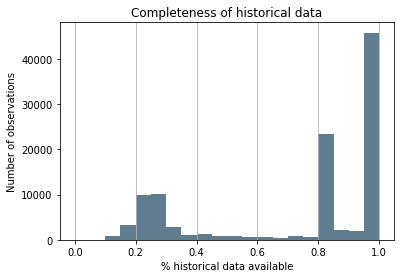

In [55]:
# Measure the completeness of each observation. What % of historical datapoints are available?
cl = []
tempdf = pd.DataFrame()
for i in range(1,nDaysLookBack*len(hours)+2):
    cn = 'avgp_minus' + str(i)
    cl.append(cn)
outputdf['pctavail'] = (outputdf[cl]>0).sum(1)
outputdf['pctavail'] = outputdf['pctavail'] / (nDaysLookBack*len(hours)+1)

outputdf['pctavail'].plot.hist(grid=True, bins=20,
                   color='#607c8e')
plt.title('Completeness of historical data')
plt.xlabel('% historical data available')
plt.ylabel('Number of observations')
plt.grid(axis='y')

In [112]:
# Create the classification variable
outputdf['closedUp'] = None
outputdf['closedUp'] = np.where(outputdf['close'] > 1, 1, 0)

In [113]:
# Final data filtering
outputdf['passCompleteness'] = 0 
outputdf['passCompleteness'] = np.where(outputdf['pctavail'] >= .95, 1, 0)

outputdf['passY'] = 0 
outputdf['passY'] = np.where(outputdf['close'] > 0, 1, 0)

outputdf['passDailyVar'] = 0
outputdf['passDailyVar'] = np.where(outputdf['badRow'] == 0, 1, 0)

outputdf['passAll'] = 0
outputdf['passAll'] = np.where((outputdf['passCompleteness'] == 1) 
                                & (outputdf['passY'] == 1) 
                                & (outputdf['passDailyVar'] == 1), 1, 0)

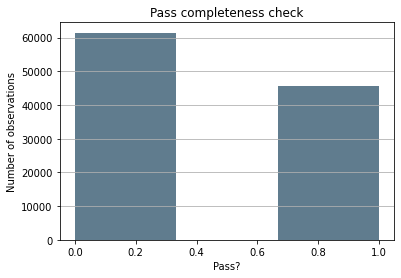

In [114]:
outputdf['passCompleteness'].plot.hist(grid=True, bins=3, color='#607c8e')
plt.title('Pass completeness check')
plt.xlabel('Pass?')
plt.ylabel('Number of observations')
plt.grid(axis='x')

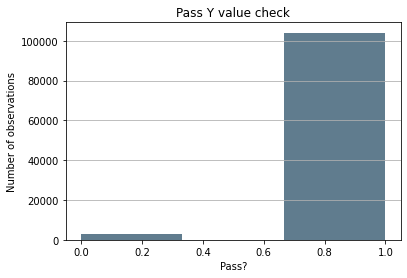

In [115]:
outputdf['passY'].plot.hist(grid=True, bins=3, color='#607c8e')
plt.title('Pass Y value check')
plt.xlabel('Pass?')
plt.ylabel('Number of observations')
plt.grid(axis='x')

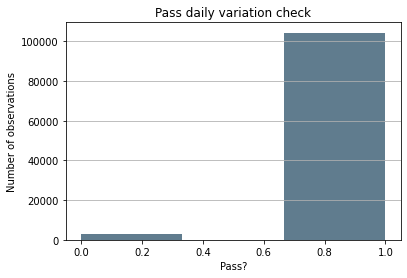

In [116]:
outputdf['passDailyVar'].plot.hist(grid=True, bins=3, color='#607c8e')
plt.title('Pass daily variation check')
plt.xlabel('Pass?')
plt.ylabel('Number of observations')
plt.grid(axis='x')

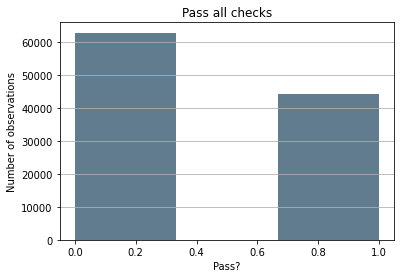

In [117]:
outputdf['passAll'].plot.hist(grid=True, bins=3, color='#607c8e')
plt.title('Pass all checks')
plt.xlabel('Pass?')
plt.ylabel('Number of observations')
plt.grid(axis='x')

In [120]:
# Export final data for analysis
finaldf = pd.DataFrame()
finaldf = outputdf.loc[outputdf['passAll'] == 1]

keepCols = ['date','symbol','passAll','pctavail','close','closedUp']
for i in range(1,nDaysLookBack*len(hours)+2):
    cn = 'avgp_minus' + str(i)
    keepCols.append(cn)

finaldf = finaldf[finaldf.columns.intersection(keepCols)]
finaldf.to_csv(os.getcwd() + '/output/final_analysis_' + datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv')

print(datetime.now().strftime("%H:%M:%S") + " -> Dataset ready for analysis.")

13:27:28 -> Dataset ready for analysis.


In [ ]:
# #OLS model: linear regression on last 5 close prices
# reg_formula = 'close_nextpct1 ~ close_lagpct1 + close_lagpct2 + close_lagpct3 + close_lagpct4 + close_lagpct5 + close_lagpct1*close_lagpct2'
# model = smf.ols(formula = reg_formula, data=data).fit()
# print(model.summary())